<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

# Iniciar Sistema

## Importar Librerias

In [2]:
#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## Conexion con Google y Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## Funciones

In [0]:
#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.33, randomDiv=52):
    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

## Importar Dataseet y clases

In [7]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


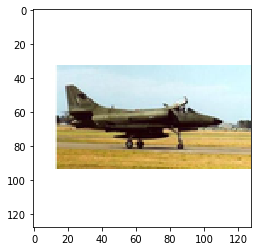

In [8]:
#show image
plot_image(x_train_all[124])

In [34]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(classes)
print(nClassesImageGenerator)

102


## Aumentar el set de datos con DataGenerator

### Creando el modelo generador de datos

In [27]:
X_train_generator, X_test_generator, y_train_generator, y_test_generator = train_test_split(
        x_train_all, salidasCategoricas, 
        test_size=0.33, 
        random_state=52)

print(X_train_generator.shape, y_train_generator.shape)
print(X_test_generator.shape, y_test_generator.shape)

(6127, 128, 128, 3) (6127, 102)
(3018, 128, 128, 3) (3018, 102)


In [0]:
modelImageGenerator = ModeloExterno(nombreModelo="wisrovi-imageGenerator", rutaBase=BASE_FOLDER)

In [53]:
#Aumentamos el dataset para tener mas datos que procesar
datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    shear_range=0.1, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

convnet_augmentation = models.Sequential()
convnet_augmentation.add(Conv2D(64,(3,3),input_shape=(128,128,3),activation='relu'))
convnet_augmentation.add(Conv2D(64,(3,3),activation='relu'))
convnet_augmentation.add(Dropout(0.25))
convnet_augmentation.add(Conv2D(64,(3,3),activation='relu'))
convnet_augmentation.add(Conv2D(64,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2,2)))
convnet_augmentation.add(Flatten())
convnet_augmentation.add(Dropout(0.25))
convnet_augmentation.add(Dense(64,activation='relu'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Dense(nClassesImageGenerator,activation='softmax'))

convnet_augmentation.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

convnet_augmentation.summary()

modelImageGenerator.GuardarModelo(convnet_augmentation)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
dropout_46 (Dropout)         (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 230400)          

True

### Preparando y entrenando el modelo Generador de datos

In [1]:
# es necesario especificar el numero de steps cuando se usa un generator (para saber cuando dejar de generar datos en una epoca)
batch_size = 32
num_samples = x_train_all.shape[0] * 10 # multiplicar por 10 el numero de ejemplos
pasos_por_epoca = num_samples//batch_size
iterator_datagen_train = datagen.flow( X_train_generator, y_train_generator,  batch_size=batch_size  )
print(pasos_por_epoca)

numeroEntrenamientos = 30
numeroEpocas = 2
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history_augmentation = convnet_augmentation.fit_generator(
        iterator_datagen_train,
        epochs=numeroEpocas,
        validation_data=(
            X_test_generator, y_test_generator
        ),
        workers=4,
        steps_per_epoch=pasos_por_epoca)
        
    plot_history(history_augmentation)
    modelImageGenerator.GuardarPesosModelo()
    print()

NameError: ignored

## Repartiendo los datos entre Train, test, eval y predic

In [0]:
imagen = 250
#print(processed_y[imagen], y_train_all[imagen])

In [28]:
classes = np.unique(processed_y)
nClasses = len(classes)
print("Numero de clases diferenes:", nClasses)
print()

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Numero de clases diferenes: 102

Training (66.98%)
X_train (6127, 128, 128, 3)
y_train (6127, 102)

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test (2022, 102)

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic (996, 102)

Distribución correcta


In [30]:
#Creamos el Set de Entrenamiento y Validación
#divido los datos de entrenamiento en dos, un 80% para el entrenamiento y otro 20% para validacion
train_X,valid_X,train_label,valid_label = train_test_split(
    X_train, y_train, 
    test_size=0.1, random_state=43)

print("training")
print(train_X.shape)
print(train_label.shape)
print()
print("Valid")
print(valid_X.shape)
print(valid_label.shape)

training
(5514, 128, 128, 3)
(5514, 102)

Valid
(613, 128, 128, 3)
(613, 102)


# Nueva Red Neuronal

## Red Neuronal

In [0]:
modelExtern = ModeloExterno(nombreModelo="wisrovi-nuevoModelo", rutaBase=BASE_FOLDER)

In [21]:
print("********** Modelo *********")

new_model = Sequential()
new_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )
new_model.add(Dense(128, activation='relu'))
new_model.add(MaxPooling2D((2, 2),padding='same'))
new_model.add(Dropout(0.5))

new_model.add(Dense(120, activation='relu'))
new_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(87, activation='relu'))
new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

#new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********


NameError: ignored

## Entrenar el modelo



Entrenamiento 1
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 25s 5ms/step - loss: 4.3398 - acc: 0.0725 - val_loss: 3.9404 - val_acc: 0.1990
Epoch 2/10
5514/5514 [==============================] - 25s 4ms/step - loss: 3.6923 - acc: 0.2285 - val_loss: 3.2941 - val_acc: 0.3263
Epoch 3/10
5514/5514 [==============================] - 25s 4ms/step - loss: 3.3140 - acc: 0.3199 - val_loss: 3.1591 - val_acc: 0.3638
Epoch 4/10
5514/5514 [==============================] - 25s 4ms/step - loss: 3.1549 - acc: 0.3337 - val_loss: 3.6119 - val_acc: 0.2496
Epoch 5/10
5514/5514 [==============================] - 25s 5ms/step - loss: 3.0708 - acc: 0.3361 - val_loss: 2.9135 - val_acc: 0.3736
Epoch 6/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.9596 - acc: 0.3480 - val_loss: 2.9571 - val_acc: 0.3556
Epoch 7/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.8763 - acc: 0.3560 - val_loss: 2.8819 - val_ac

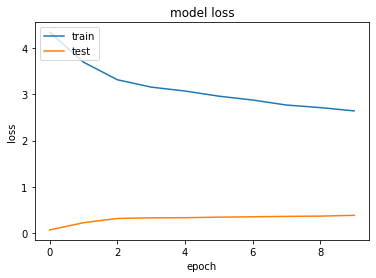

Pesos Guardados!
2022/2022 [==============================] - 3s 1ms/step
Test loss: 2.8680389300062443
Test accuracy: 0.36795252228467096
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.5405 - acc: 0.3961 - val_loss: 2.7751 - val_acc: 0.3850
Epoch 2/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.4679 - acc: 0.4030 - val_loss: 2.8236 - val_acc: 0.3866
Epoch 3/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.3540 - acc: 0.4222 - val_loss: 2.8204 - val_acc: 0.3719
Epoch 4/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.2843 - acc: 0.4313 - val_loss: 2.8963 - val_acc: 0.3850
Epoch 5/10
5514/5514 [==============================] - 25s 4ms/step - loss: 2.1961 - acc: 0.4411 - val_loss: 2.9740 - val_acc: 0.3817
Epoch 6/10
5514/5514 [==============================] - 25s 5ms/step - loss: 2.1189 - acc: 0.4521 - val_

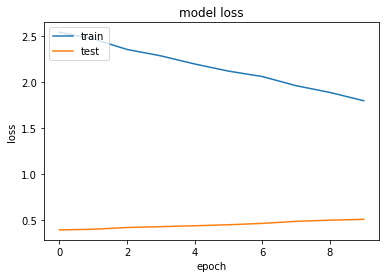

Pesos Guardados!
2022/2022 [==============================] - 3s 1ms/step
Test loss: 3.377488514554017
Test accuracy: 0.3778437191047489
***************



In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 2 

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 10

for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
        validation_data=(valid_X, valid_label)
        )
        
    plot_history(history)
    modelExtern.GuardarPesosModelo()
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])
    print("***************")    
    print()

In [0]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2022/2022 [==============================] - 3s 1ms/step
Test loss: 3.377488514554017
Test accuracy: 0.3778437191047489


In [0]:
modelExtern.GuardarPesosModelo()

Pesos Guardados!


True

## Cargar Modelo Red Neuronal Guardado

In [0]:
modeloCargado = modelExtern.CargarModeloGuardado(True)

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!
Modelo compilado!


In [0]:
#valido el modelo
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

996/996 [==============================] - 2s 2ms/step
Test loss: 3.470456121437042
Test accuracy: 0.357429718875502


# Reentrenar un modelo de ImageNet

## Cargar Modelo ImageNet

In [0]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()





58892288/58889256 [==============================] - 2s 0us/step






<keras.engine.input_layer.InputLayer object at 0x7f8b6b527470> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b527ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b527c18> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8b6b510f60> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b4d4a58> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b4d9400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8b6b4e0080> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b4e56d8> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b4ec860> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b4f25c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8b6b4fc5c0> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b504c88> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6b48b780> False
<keras.layers.convolutional.Conv2D object at 0x7f8b6

## Crear nuestro modelo e incluirle el modelo de imageNet

In [0]:
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo="transfer-wisrovi", rutaBase=BASE_FOLDER)

In [0]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          147488    
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 102)               52326     
Total params: 14,914,502
Trainable params: 7,279,238
Non-trainable params: 7,635,264
___________________________________

True

## Entrenar Modelo Con conocimiento Transferido

Int:  (5514, 128, 128, 3)
Out:  (5514, 102)


Entrenamiento 1
Train on 5514 samples, validate on 613 samples
Epoch 1/15
5514/5514 [==============================] - 7s 1ms/step - loss: 8.5810 - acc: 0.2169 - val_loss: 3.1006 - val_acc: 0.3850
Epoch 2/15
5514/5514 [==============================] - 7s 1ms/step - loss: 2.5121 - acc: 0.4742 - val_loss: 2.0411 - val_acc: 0.5840
Epoch 3/15
5514/5514 [==============================] - 7s 1ms/step - loss: 1.4166 - acc: 0.6850 - val_loss: 1.5252 - val_acc: 0.6835
Epoch 4/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.7109 - acc: 0.8348 - val_loss: 1.3655 - val_acc: 0.7455
Epoch 5/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.3837 - acc: 0.9075 - val_loss: 1.2712 - val_acc: 0.7635
Epoch 6/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.2212 - acc: 0.9465 - val_loss: 1.2160 - val_acc: 0.7798
Epoch 7/15
5514/5514 [==============================] - 7s 1ms/step - loss: 0.1635 - ac

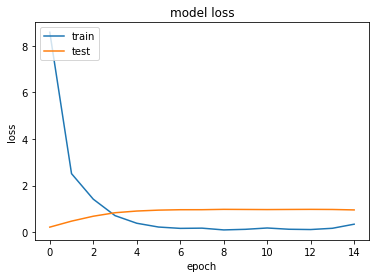

Pesos Guardados!
2022/2022 [==============================] - 2s 992us/step
Test loss: 1.824807028388411
Test accuracy: 0.7922848664688428
***************



In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 1

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label)
        )
        
    plot_history(history)
    modeloTrasnferenciaConocimiento.GuardarPesosModelo()

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])
    print("***************")    
    print()

In [0]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(True)

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!
Modelo compilado!


In [0]:
#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

996/996 [==============================] - 2s 2ms/step
Test loss: 1.8598708330866802
Test accuracy: 0.7831325301204819


In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'